<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Rede_Siamesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import cv2
import os

size = 28

# Coisas pra fazer 
# 1 - passar as funções de redimensionamento, reshape, normalização(1/255)
# Para poder gerar o dataset sem se importar com a resolução e fazer o minimo de mudanças pra vê se gasta menos memoria
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing

# Datasets

## Funções

In [2]:
def visualize(dataset):
  """Visualize a few triplets from the supplied batches."""
  for anchor, positive, negative in dataset.take(1):
    def show(ax, image):
        ax.imshow(image, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[0])
        show(axs[i, 1], positive[0])
        show(axs[i, 2], negative[0])

### Mnist

In [3]:
def resize(im, nR, nC):
    number_rows = len(im)     # source number of rows 
    number_columns = len(im[0])  # source number of columns 
    return [[ im[int(number_rows * r / nR)][int(number_columns * c / nC)]  
                 for c in range(nC)] for r in range(nR)]


def pre_process(img):
  #img = np.resize(img,(size,size)) #resize(img, size, size) 
  img = np.array([img]) 
  img = img.reshape(1, size, size)
  return img


def dataset_keras_mnist(quantidade_imagens):
  (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()
  del x_test_origin
  del y_test_origin

  nb_classes = 10
  triplets=[np.zeros((quantidade_imagens, 1, size, size)) for i in range(3)]

  for i in range(quantidade_imagens):
    if i == 20000: print("20.000 imegens adicionadas.")
    if i == 25000: print("25.000 imegens adicionadas.")
    if i == 30000: print("30.000 imegens adicionadas.")
    if i == 35000: print("35.000 imegens adicionadas.")
    if i == 36000: print("36.000 imegens adicionadas.")
    if i == 37000: print("37.000 imegens adicionadas.")
    if i == 38000: print("38.000 imegens adicionadas.")
    if i == 39000: print("39.000 imegens adicionadas.")
    if i == 39900: print("40.000 imegens adicionadas.")

    anchor_class = np.random.randint(0, nb_classes) # Sorteia o indice de uma das classes de 0 a 9
    nb_sample_available_for_class_AP = x_train_origin[anchor_class].shape[0] # verifica a quantidade de imagens na classe de indice anchor_class
 
    # imagem ancora
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_A = np.random.randint(0, nb_sample_available_for_class_AP)
      if y_train_origin[idx_A] == anchor_class:
        break 

    # imagem positiva
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_P = np.random.randint(0, nb_sample_available_for_class_AP)
      if y_train_origin[idx_P] == anchor_class:
        break  
    
    # Imagem negativa
    negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes # seleciona uma outra classe para ser a negativa
    nb_sample_available_for_class_N = x_train_origin[negative_class].shape[0]
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_N = np.random.randint(0, nb_sample_available_for_class_N)
      if y_train_origin[idx_N] == negative_class:
        break

    triplets[0][i,:,:,:] = pre_process(x_train_origin[idx_A])
    triplets[1][i,:,:,:] = pre_process(x_train_origin[idx_P])
    triplets[2][i,:,:,:] = pre_process(x_train_origin[idx_N])
 
  dataset = tf.data.Dataset.zip((
  tf.data.Dataset.from_tensor_slices(triplets[0]), # anchor_dataset
  tf.data.Dataset.from_tensor_slices(triplets[1]), # positive_dataset
  tf.data.Dataset.from_tensor_slices(triplets[2]))) # positive_dataset
  return dataset 

## Gerar DataSet

In [4]:
dataset = dataset_keras_mnist(quantidade_imagens = 40000)
dataset = dataset.shuffle(buffer_size=1024)
#visualize(dataset)

train_ds = dataset.take(round(len(dataset) * 0.8))
val_ds = dataset.skip(round(len(dataset) * 0.8))

print("Total de imagens: " + str(len(dataset)))
print("   Treinamento: " + str(len(train_ds)))
print("   Validação: " + str(len(val_ds)))


train_ds = train_ds.batch(32, drop_remainder=False)
val_ds = val_ds.batch(32, drop_remainder=False)
train_ds = train_ds.prefetch(8)
val_ds = val_ds.prefetch(8)

20.000 imegens adicionadas.
25.000 imegens adicionadas.
30.000 imegens adicionadas.
35.000 imegens adicionadas.
36.000 imegens adicionadas.
37.000 imegens adicionadas.
38.000 imegens adicionadas.
39.000 imegens adicionadas.
40.000 imegens adicionadas.
Total de imagens: 40000
   Treinamento: 32000
   Validação: 8000


# Modelo

In [6]:
#### PART OF THIS CODE IS USING CODE FROM VICTOR SY WANG: https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/utils.py ####
#### THIS FILE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/fr_utils.py

import tensorflow as tf
import numpy as np
import os
import cv2
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import matplotlib.pyplot as plt


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict
    
def img_to_encoding(image_path, model):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [11]:
#### THIS CODE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/inception_blocks_v2.py

import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras import backend as K
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input #, concatenate
from keras.models import Model

#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
#import fr_utils
from keras.layers.core import Lambda, Flatten, Dense

def inception_block_1a(X):
    """
    Implementation of an inception block
    """
    
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
   
    # CONCAT
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1, name="concat_inception_block_1a")

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_1c(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_2a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    
    return inception

def inception_block_2b(X):
    #inception4e
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_3a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_3b(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    
    return inception

def model(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    Resize_layer = keras.layers.Resizing(96,96)
    scale_layer  = keras.layers.Rescaling(scale=1./255)
    X = Resize_layer(X_input)
    X = scale_layer(X)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
  
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='model')
        
    return model

In [12]:
# https://keras.io/examples/vision/siamese_network/
# https://keras.io/examples/vision/siamese_contrastive/
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
tf.keras.backend.set_image_data_format('channels_first')

input_shape = (1, 96,96)


class DistanceLayer(keras.layers.Layer):
  """
  This layer is responsible for computing the distance between the anchor
  embedding and the positive embedding, and the anchor embedding and the
  negative embedding.
  """

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)



embedding_model = model(input_shape = input_shape)
embedding_model.summary()

def Siamese_Network():
  anchor_input = keras.layers.Input(name="anchor", shape= input_shape)
  positive_input = keras.layers.Input(name="positive", shape=input_shape)
  negative_input = keras.layers.Input(name="negative", shape=input_shape)

  distances = DistanceLayer()(
      embedding_model(anchor_input),
      embedding_model(positive_input),
      embedding_model(negative_input),
    )

  return keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name='Siamese_Network')

ValueError: ignored

In [14]:
class SiameseModel(keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.3):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Treinamento

In [15]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True),
  ]

In [16]:
siamese_model = SiameseModel(Siamese_Network())
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001), weighted_metrics=["loss"])

In [17]:
historico = siamese_model.fit(train_ds, epochs=30, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model.h5")

Epoch 1/30


ValueError: ignored

In [ ]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,2,2)
  plt.title(nome + ": Variação do Loss")
  plt.xlabel("Epocas")
  plt.ylabel("Diferença")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()


grafico(historico, "Rede Siamesa")

# Teste

## Funções

In [ ]:
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def visualize(x_test_origin):
    """Visualize a few triplets from the supplied batches."""
    print("Total de imagens: {0}  Resolução: {1}x{2}".format(x_test_origin.shape[0], x_test_origin.shape[1], x_test_origin.shape[2]))
    def show(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 1], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 2], x_test_origin[np.random.randint(0, 1000)])

In [ ]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def array_to_imagem(image, novo_nome):
  novo_nome = "/content/imagens/" + novo_nome + ".jpg"
  cv2.imwrite(novo_nome, image)

def salvar_ancoras(x_test_origin, y_test_origin):
  os.mkdir("imagens")
  

  indice = 0
  i = 0
  while indice < 10:
    if y_test_origin[i] == indice:
      array_to_imagem(x_test_origin[i], nome[indice])
      indice += 1
    i+= 1

In [ ]:
def ler_imagem(local):
  return cv2.imread(local, 0)

In [ ]:
def prepare_database(model):
  database = {}
  local = "/content/imagens"
  for imagem in os.listdir(local):
    local_imagem = os.path.join(local, imagem)
    img = ler_imagem(local_imagem)
    identity = os.path.splitext(os.path.basename(local_imagem))[0]
    database[identity] = img_to_encoding(img, model)
  
  return database

In [ ]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [ ]:
def img_to_encoding(img, model):
 # img = np.resize(image,(size,size))
  img = np.array([img]) 
  img = img.reshape(img.shape[0], 1, size, size)

  embedding = model.predict(img, verbose=0)
  
  return embedding

In [ ]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

Total de imagens: 10000  Resolução: 28x28


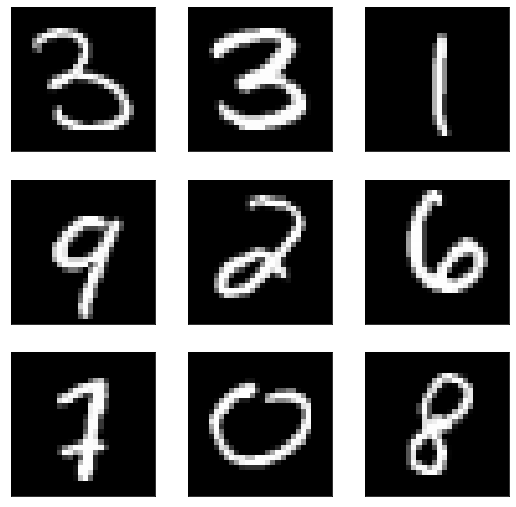

In [ ]:
# Permite visualizar algumas imagens do conjunto de teste
visualize(x_test_origin)

In [ ]:
# salvar uma imagem de cada classe para ser a ancora
salvar_ancoras(x_test_origin, y_test_origin)

Para classificar um imagem como pertencente a uma das classe, o processo é dividido em 4 fasses: \

1 - uma imagem representando cada classe é codificada. \

2 - a imagem que sera classifica é codificada. \

3 - verifica a distancia da imagem codificada na fasse 2 com cada uma das imagens codificadas na fasse 1. \

4 - a imagem sera classificada de acordo com a menor distancia encontrada na fasse 3.


In [ ]:
embedding_model = tf.keras.models.load_model("/content/embedding_model.h5")

In [ ]:
database = prepare_database(embedding_model)
saida = []

for i in range(15): # o maximo é 10000
  classe = recognise_class(x_test_origin[i], database, embedding_model)
  print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[i], classe, i))
  saida.append([y_test_origin[i], classe])

metricas(saida) 

In [ ]:
imagens = cv2.imread("/content/temp.jpg", 0)

database = prepare_database(embedding_model)

classe = recognise_class(imagens, database, embedding_model)
print(classe)

In [ ]:
# verifica as imagem que deram errado
cv2.imwrite("teste.jpg",x_test_origin[7])